# VQA-RAD Data Preprocessing

This notebook processes the VQA-RAD dataset:
1. Downloads data from Google Drive
2. Filters for high-quality questions (2-annotator validation)
3. Splits into closed-ended and open-ended datasets
4. Filters images to match the processed questions
5. Analyzes and visualizes the data distributions

## Library Imports

In [59]:
import pandas as pd
import gdown
import os
import json
import matplotlib.pyplot as plt
import zipfile
import shutil

## Variables

In [60]:
# Google Drive URLs
VQARAD_JSON_URL = "https://drive.google.com/file/d/1lcq8ZaTrvMIXOdzFKznO-2Oxeix1Y7py/view?usp=drive_link"
VQARAD_IMAGES_ZIP_URL = "https://drive.google.com/file/d/1RYR2xHBVyM6C2NsYGxKy3vIw9W6UahuA/view?usp=drive_link"

# File paths
VQARAD_JSON = "VQA_RAD_Dataset_Public.json"
VQARAD_IMAGES_ZIP = "VQA_RAD_Images.zip"

# Folders
FOLDERS = [
    "JSON_Files",
    "CSV_Files",
    "Images",
    "Filtered_Images"
]

## Helper Functions

In [61]:
def create_required_folders(folders):
    """Create necessary folders for organizing data"""
    for folder in folders:
        os.makedirs(folder, exist_ok=True)

create_required_folders(FOLDERS)

In [62]:
def download_from_googledrive(url, output_filename):
    """Download file from Google Drive if it doesn't exist"""
    if not os.path.exists(output_filename):
        print(f"File '{output_filename}' is not downloaded")
        print("Downloading from google drive....")
        gdown.download(url, output=output_filename, fuzzy=True)
    else:
        print(f"File '{output_filename}' exists. Will not be downloaded from google drive")
    return output_filename

## Dataset Download

In [63]:
# Download JSON dataset
json_path = download_from_googledrive(VQARAD_JSON_URL, VQARAD_JSON)

# Download images zip
images_zip_path = download_from_googledrive(VQARAD_IMAGES_ZIP_URL, VQARAD_IMAGES_ZIP)

File 'VQA_RAD_Dataset_Public.json' exists. Will not be downloaded from google drive
File 'VQA_RAD_Images.zip' exists. Will not be downloaded from google drive


In [64]:
# Unzip images if not already extracted
if not os.path.exists("Images/VQA_RAD_Images"):
    print("Extracting images...")
    with zipfile.ZipFile(images_zip_path, 'r') as zip_ref:
        zip_ref.extractall("Images")
    print("Images extracted to Images/ folder")
else:
    print("Images already extracted")

Extracting images...
Images extracted to Images/ folder


## Load and Convert JSON to DataFrame

In [65]:
def json_to_pandas(json_file, save_to_csv=False, csv_folder="CSV_Files"):
    """Convert JSON file to pandas DataFrame"""
    try:
        with open(json_file, "r", encoding="utf-8") as file:
            data = json.load(file)

        if isinstance(data, dict):
            data = [data]

        df = pd.DataFrame(data)

    except json.JSONDecodeError:
        records = []
        with open(json_file, "r", encoding="utf-8") as file:
            for line in file:
                line = line.strip()
                if line:
                    records.append(json.loads(line))
        df = pd.DataFrame(records)

    if save_to_csv:
        csv_name = f"{os.path.splitext(os.path.basename(json_file))[0]}.csv"
        csv_path = os.path.join(csv_folder, csv_name)

        if not os.path.exists(csv_path):
            print(f"Creating csv file for {json_file}...")
            df.to_csv(csv_path, index=False)
            print(f"Created a csv to '{csv_path}' for '{json_file}'")
        else:
            print(f"csv file for {json_file} already exists at {csv_path}")

    return df

In [95]:
# Load raw VQA-RAD data
df_raw = json_to_pandas(json_path, save_to_csv=True)

print(f"\nRaw dataset loaded: {len(df_raw)} questions")
print(f"Columns: {df_raw.columns.tolist()}")
print("\nFirst 3 rows:")
df_raw.head(3)

csv file for VQA_RAD_Dataset_Public.json already exists at CSV_Files/VQA_RAD_Dataset_Public.csv

Raw dataset loaded: 2248 questions
Columns: ['qid', 'phrase_type', 'qid_linked_id', 'image_case_url', 'image_name', 'image_organ', 'evaluation', 'question', 'question_rephrase', 'question_relation', 'question_frame', 'question_type', 'answer', 'answer_type']

First 3 rows:


,qid,phrase_type,qid_linked_id,image_case_url,image_name,image_organ,evaluation,question,question_rephrase,question_relation,question_frame,question_type,answer,answer_type
0,0,freeform,03f451ca-de62-4617-9679-e836026a7642,https://medpix.nlm.nih.gov/case?id=48e1dd0e-85...,synpic54610.jpg,HEAD,not evaluated,Are regions of the brain infarcted?,NULL,NULL,NULL,PRES,Yes,CLOSED
1,1,freeform,06e26b2c-04b9-42bc-8e98-1de30a0f7682,https://medpix.nlm.nih.gov/case?id=b197277b-69...,synpic29265.jpg,CHEST,not evaluated,Are the lungs normal appearing?,NULL,NULL,NULL,ABN,No,CLOSED
2,2,freeform,0d0e8b6b-7753-4788-9b6d-dc7f25250c3f,https://medpix.nlm.nih.gov/case?id=b197277b-69...,synpic29265.jpg,CHEST,not evaluated,Is there evidence of a pneumothorax,NULL,NULL,NULL,PRES,No,CLOSED


## Data Filtering - Quality Control

Filter to keep only questions validated by 2 clinical annotators (evaluation = "evaluated" or "given")

In [67]:
def filter_by_evaluation(df, save_to_csv=True, csv_folder="CSV_Files"):
    """Filter dataset to keep only 2-annotator validated questions"""
    print("\n" + "="*60)
    print("QUALITY FILTERING: 2-Annotator Validation")
    print("="*60)
    
    print(f"\nBefore filtering: {len(df)} questions")
    print("\nEvaluation breakdown:")
    print(df['evaluation'].value_counts())
    
    # Filter: keep only evaluated or given
    df_filtered = df[df['evaluation'].isin(['evaluated', 'given'])].copy()
    
    removed = len(df) - len(df_filtered)
    print(f"\nAfter filtering: {len(df_filtered)} questions")
    print(f"Removed: {removed} questions ({removed/len(df)*100:.1f}%)")
    
    if save_to_csv:
        csv_path = os.path.join(csv_folder, "vqarad_filtered_evaluated.csv")
        if not os.path.exists(csv_path):
            df_filtered.to_csv(csv_path, index=False)
            print(f"\nSaved: {csv_path}")
    
    return df_filtered

print("Filter function defined")

Filter function defined


In [68]:
# Apply quality filter
df_filtered = filter_by_evaluation(df_raw)


QUALITY FILTERING: 2-Annotator Validation

Before filtering: 2248 questions

Evaluation breakdown:
evaluation
evaluated        1448
not evaluated     557
given             243
Name: count, dtype: int64

After filtering: 1691 questions
Removed: 557 questions (24.8%)


## Data Analysis - Unique Values

In [69]:
def df_unique_values(df, MAX_VALUES=10, col=None):
    """Display unique values and counts for DataFrame columns"""
    
    print("\n================== UNIQUE VALUES REPORT ==================\n")

    if col is not None:
        if col not in df.columns:
            print(f"Column '{col}' does not exist in the DataFrame.")
            return
        
        unique_vals = df[col].unique()
        num_unique = len(unique_vals)

        print(f"Column Name: {col}")

        if num_unique > MAX_VALUES:
            print(f"  Unique Values ({num_unique} total): showing first {MAX_VALUES}")
            print(f"  {list(unique_vals[:MAX_VALUES])}")
        else:
            print(f"  Unique Values ({num_unique} total):")
            print(f"  {unique_vals}")

        print("\n  Value Counts:")
        print(df[col].value_counts().head(MAX_VALUES))

        print("\n====================== END REPORT ======================\n")
        return
    
    for col in df.columns:
        print(f"Column Name: {col}")
        unique_vals = df[col].unique()
        num_unique = len(unique_vals)

        if num_unique > MAX_VALUES:
            print(f"  Unique Values ({num_unique} total): showing first {MAX_VALUES}")
            print(f"  {list(unique_vals[:MAX_VALUES])}")
        else:
            print(f"  Unique Values ({num_unique} total):")
            print(f"  {unique_vals}")

        print("\n  Value Counts:")
        print(df[col].value_counts().head(MAX_VALUES))
        print("\n--------------------------------------------------------------\n")

    print("========================== END REPORT =========================\n")

In [70]:
# Focus on key columns
df_unique_values(df_filtered, col="answer_type")


================== UNIQUE VALUES REPORT ==================

Column Name: answer_type
  Unique Values (2 total):
  ['OPEN' 'CLOSED']

  Value Counts:
answer_type
CLOSED    956
OPEN      735
Name: count, dtype: int64

====================== END REPORT ======================



In [71]:
df_unique_values(df_filtered, col="question_type")


================== UNIQUE VALUES REPORT ==================

Column Name: question_type
  Unique Values (23 total): showing first 10
  ['MODALITY', 'ORGAN', 'PLANE', 'COUNT', 'SIZE', 'PRES', 'ABN', 'POS', 'OTHER', 'ATTRIB']

  Value Counts:
question_type
PRES        562
POS         257
MODALITY    185
ABN         149
SIZE        125
PLANE       120
OTHER        74
ATTRIB       73
ORGAN        58
COLOR        41
Name: count, dtype: int64

====================== END REPORT ======================



In [72]:
df_unique_values(df_filtered, col="image_organ")


================== UNIQUE VALUES REPORT ==================

Column Name: image_organ
  Unique Values (3 total):
  ['CHEST' 'HEAD' 'ABD']

  Value Counts:
image_organ
CHEST    610
ABD      544
HEAD     537
Name: count, dtype: int64

====================== END REPORT ======================



## Data Visualization

In [73]:
def plot_distribution(df, col=None, x_label="x_label", y_label="y_label", title="title", display_counts=True):
    """Plot bar chart distribution for a column"""
    counts = df[col].value_counts()

    plt.figure()
    ax = counts.plot(kind="bar")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    if display_counts:
        for i, v in enumerate(counts.values):
            ax.text(i, v + (0.01 * v), str(v), ha='center', va='bottom')

    plt.show()

In [74]:
def plot_grouped_stacked_bar(df, groupby_cols, x_label="x_label", y_label="y_label", title="title", display_counts=True):
    """Plot stacked bar chart for grouped data"""
    cross = df.groupby(groupby_cols).size().unstack(fill_value=0)

    ax = cross.plot(kind="bar", stacked=True)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    if display_counts:
        for i, row in enumerate(cross.values):
            total = sum(row)
            ax.text(i, total + (0.01 * total), str(total), ha='center', va='bottom')

    plt.show()

    print("\nBreakdown Table:")
    print(cross)
    print("\n--------------------------------------------\n")

## Visualize Filtered Data

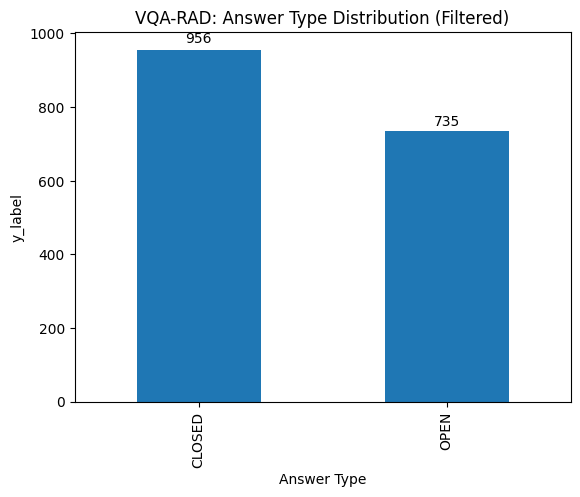

In [75]:
# Answer type distribution
plot_distribution(df_filtered, col="answer_type", 
                 x_label="Answer Type", 
                 title="VQA-RAD: Answer Type Distribution (Filtered)")

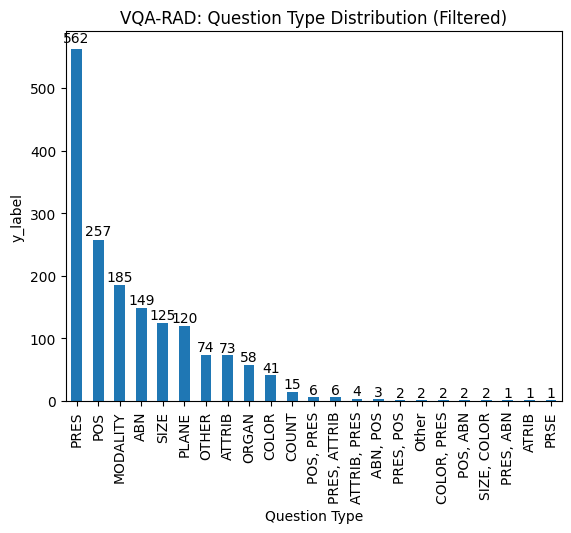

In [76]:
# Question type distribution
plot_distribution(df_filtered, col="question_type",
                 x_label="Question Type",
                 title="VQA-RAD: Question Type Distribution (Filtered)")

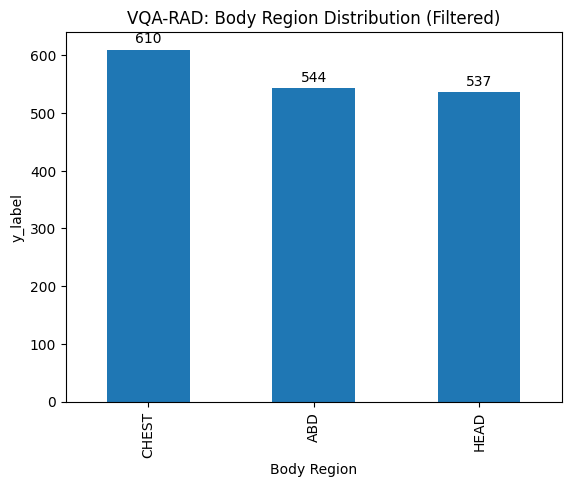

In [77]:
# Image organ distribution
plot_distribution(df_filtered, col="image_organ",
                 x_label="Body Region",
                 title="VQA-RAD: Body Region Distribution (Filtered)")

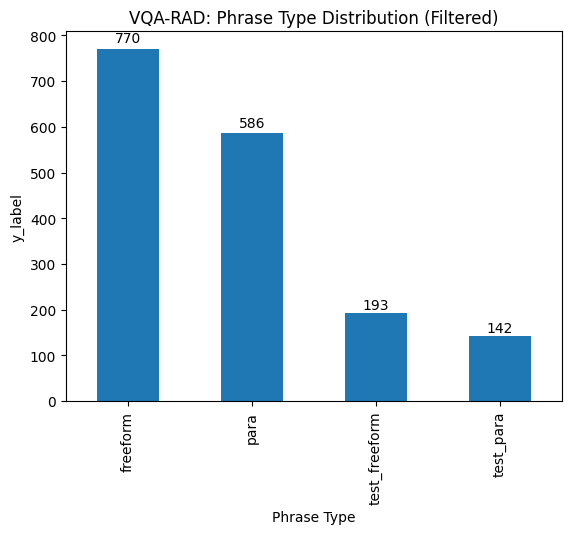

In [78]:
# Phrase type distribution
plot_distribution(df_filtered, col="phrase_type",
                 x_label="Phrase Type",
                 title="VQA-RAD: Phrase Type Distribution (Filtered)")

## Grouped Analysis

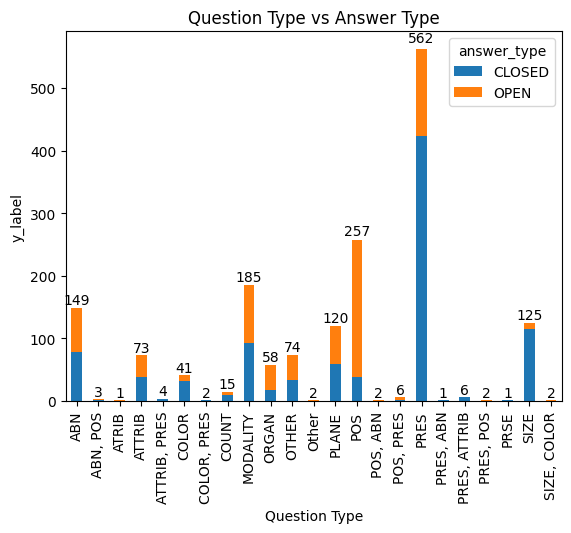


Breakdown Table:
answer_type    CLOSED  OPEN
question_type              
ABN                79    70
ABN, POS            2     1
ATRIB               0     1
ATTRIB             39    34
ATTRIB, PRES        4     0
COLOR              32     9
COLOR, PRES         2     0
COUNT              10     5
MODALITY           92    93
ORGAN              17    41
OTHER              34    40
Other               0     2
PLANE              59    61
POS                38   219
POS, ABN            0     2
POS, PRES           2     4
PRES              423   139
PRES, ABN           1     0
PRES, ATTRIB        6     0
PRES, POS           0     2
PRSE                1     0
SIZE              115    10
SIZE, COLOR         0     2

--------------------------------------------



In [79]:
# Question type vs Answer type
plot_grouped_stacked_bar(df_filtered, 
                        groupby_cols=["question_type", "answer_type"],
                        x_label="Question Type",
                        title="Question Type vs Answer Type")

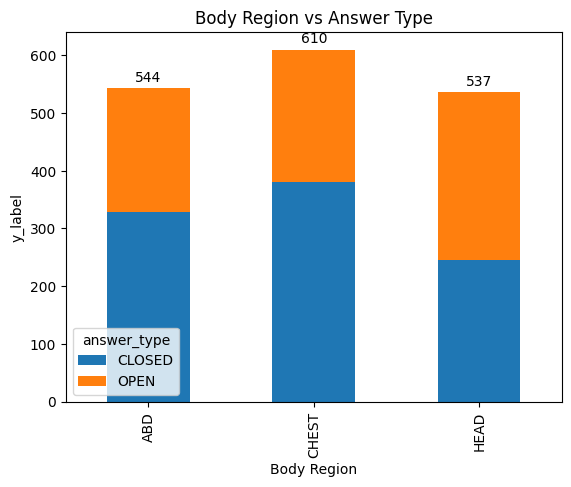


Breakdown Table:
answer_type  CLOSED  OPEN
image_organ              
ABD             329   215
CHEST           381   229
HEAD            246   291

--------------------------------------------



In [80]:
# Image organ vs Answer type
plot_grouped_stacked_bar(df_filtered,
                        groupby_cols=["image_organ", "answer_type"],
                        x_label="Body Region",
                        title="Body Region vs Answer Type")

## Split into Closed and Open Datasets

In [81]:
def drop_rows(df, col_to_drop, target, save_to_csv=True, csv_file="Updated_full_data.csv", csv_folder="CSV_Files"):
    """Filter out rows where column equals target value
    
    Adapted from SLAKE preprocessing (data_preprocessing_SLAKE.ipynb)
    """
    df_filtered = df[df[col_to_drop] != target]

    if save_to_csv:
        if not os.path.exists(csv_folder):
            os.makedirs(csv_folder)

        csv_path = os.path.join(csv_folder, csv_file)

        if not os.path.exists(csv_path):
            df_filtered.to_csv(csv_path, index=False)
            print(f"New csv file name {csv_file}")
        else:
            print(f"csv file already exists at {csv_path}")

    return df_filtered

In [82]:
# Create closed-ended dataset (remove OPEN questions)
df_closed = drop_rows(df_filtered, "answer_type", "OPEN", 
                     csv_file="vqarad_CLOSED.csv")

# Create open-ended dataset (remove CLOSED questions)
df_open = drop_rows(df_filtered, "answer_type", "CLOSED",
                   csv_file="vqarad_OPEN.csv")

print(f"\nClosed-ended dataset: {len(df_closed)} questions")
print(f"Open-ended dataset: {len(df_open)} questions")

csv file already exists at CSV_Files/vqarad_CLOSED.csv
csv file already exists at CSV_Files/vqarad_OPEN.csv

Closed-ended dataset: 956 questions
Open-ended dataset: 735 questions


In [83]:
# Save closed dataset as JSON
json_closed_path = os.path.join("JSON_Files", "vqarad_CLOSED.json")
if not os.path.exists(json_closed_path):
    df_closed.to_json(json_closed_path, orient='records', indent=2)
    print(f"Saved: {json_closed_path}")
else:
    print(f"Already exists: {json_closed_path}")

# Save open dataset as JSON
json_open_path = os.path.join("JSON_Files", "vqarad_OPEN.json")
if not os.path.exists(json_open_path):
    df_open.to_json(json_open_path, orient='records', indent=2)
    print(f"Saved: {json_open_path}")
else:
    print(f"Already exists: {json_open_path}")

Already exists: JSON_Files/vqarad_CLOSED.json
Already exists: JSON_Files/vqarad_OPEN.json


## Analyze Closed-Ended Dataset


CLOSED-ENDED DATASET ANALYSIS


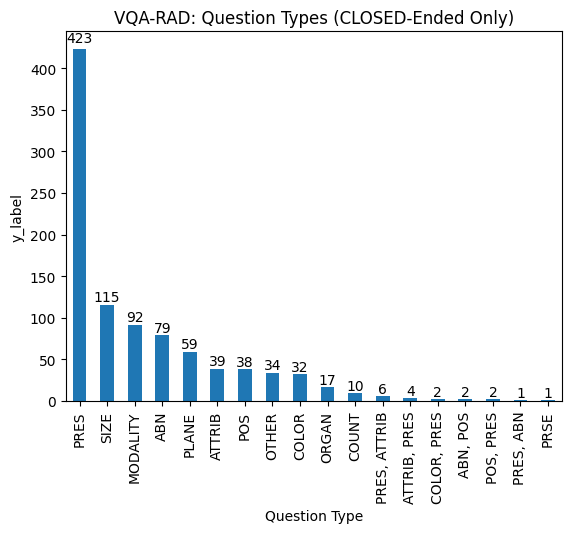

In [84]:
print("\n" + "="*60)
print("CLOSED-ENDED DATASET ANALYSIS")
print("="*60)

plot_distribution(df_closed, col="question_type",
                 x_label="Question Type",
                 title="VQA-RAD: Question Types (CLOSED-Ended Only)")

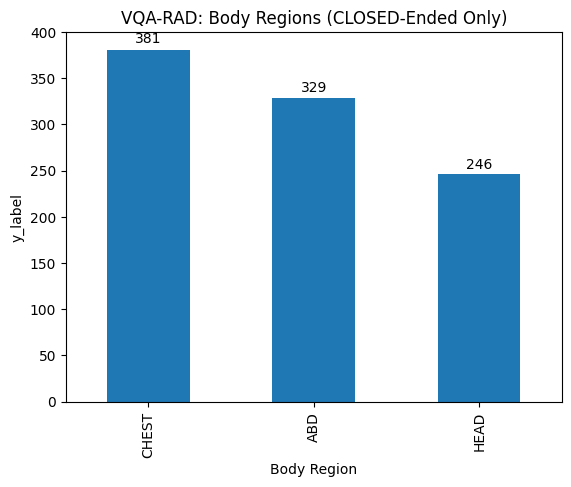

In [85]:
plot_distribution(df_closed, col="image_organ",
                 x_label="Body Region",
                 title="VQA-RAD: Body Regions (CLOSED-Ended Only)")

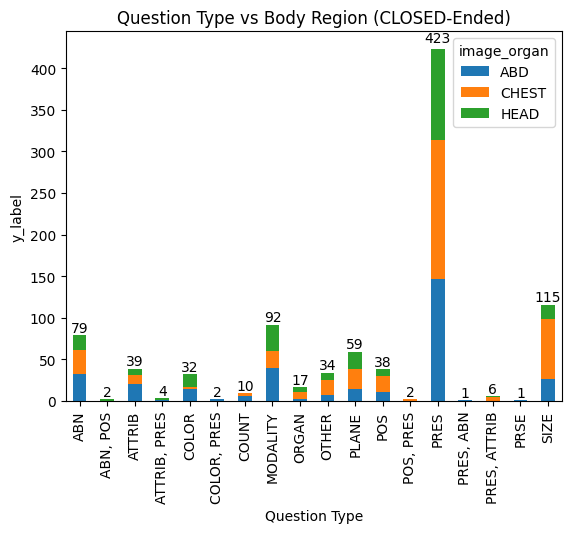


Breakdown Table:
image_organ    ABD  CHEST  HEAD
question_type                  
ABN             33     29    17
ABN, POS         0      0     2
ATTRIB          21     10     8
ATTRIB, PRES     1      0     3
COLOR           15      2    15
COLOR, PRES      2      0     0
COUNT            6      4     0
MODALITY        40     20    32
ORGAN            3      8     6
OTHER            7     18     9
PLANE           15     24    20
POS             11     19     8
POS, PRES        0      2     0
PRES           147    167   109
PRES, ABN        1      0     0
PRES, ATTRIB     0      5     1
PRSE             1      0     0
SIZE            26     73    16

--------------------------------------------



In [86]:
plot_grouped_stacked_bar(df_closed,
                        groupby_cols=["question_type", "image_organ"],
                        x_label="Question Type",
                        title="Question Type vs Body Region (CLOSED-Ended)")

## Analyze Open-Ended Dataset


OPEN-ENDED DATASET ANALYSIS


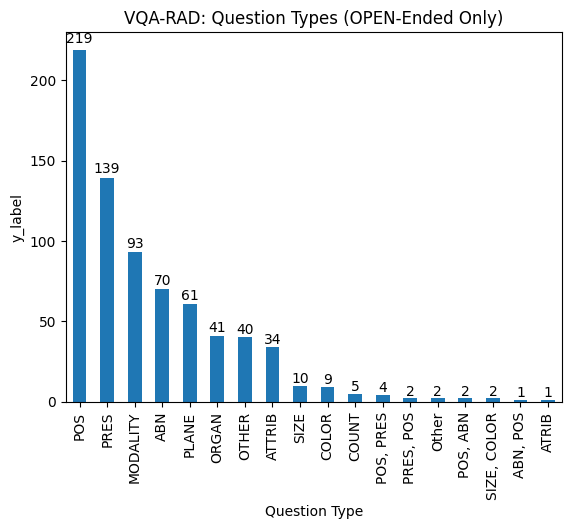

In [87]:
print("\n" + "="*60)
print("OPEN-ENDED DATASET ANALYSIS")
print("="*60)

plot_distribution(df_open, col="question_type",
                 x_label="Question Type",
                 title="VQA-RAD: Question Types (OPEN-Ended Only)")

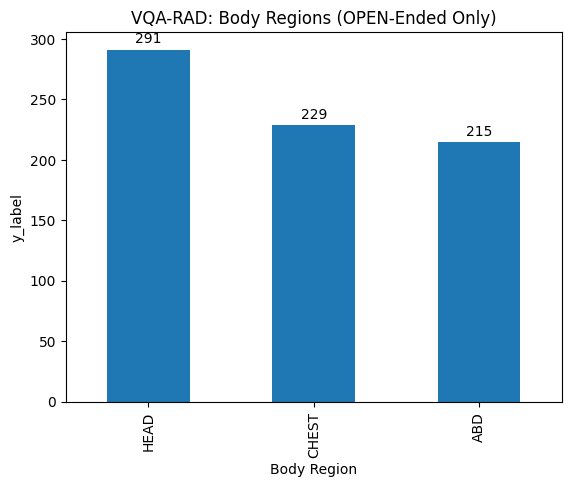

In [88]:
plot_distribution(df_open, col="image_organ",
                 x_label="Body Region",
                 title="VQA-RAD: Body Regions (OPEN-Ended Only)")

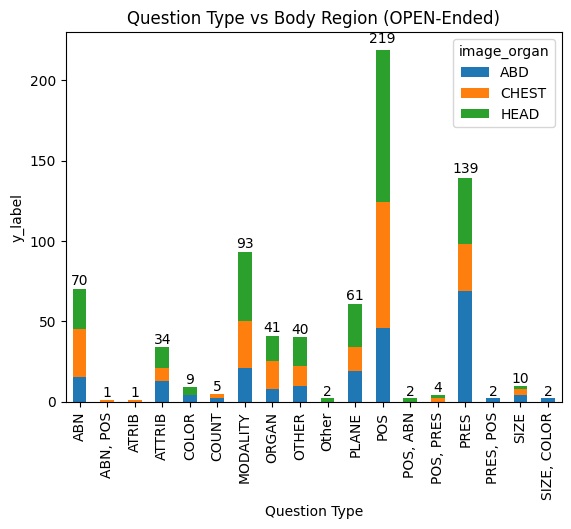


Breakdown Table:
image_organ    ABD  CHEST  HEAD
question_type                  
ABN             15     30    25
ABN, POS         0      1     0
ATRIB            0      1     0
ATTRIB          13      8    13
COLOR            4      0     5
COUNT            2      3     0
MODALITY        21     29    43
ORGAN            8     17    16
OTHER           10     12    18
Other            0      0     2
PLANE           19     15    27
POS             46     78    95
POS, ABN         0      0     2
POS, PRES        0      2     2
PRES            69     29    41
PRES, POS        2      0     0
SIZE             4      4     2
SIZE, COLOR      2      0     0

--------------------------------------------



In [89]:
plot_grouped_stacked_bar(df_open,
                        groupby_cols=["question_type", "image_organ"],
                        x_label="Question Type",
                        title="Question Type vs Body Region (OPEN-Ended)")

## Image Filtering

Filter images to match the processed datasets

In [90]:
def filter_images(df, source_folder, output_folder):
    """Copy only the images needed for the filtered dataset"""
    
    # Get unique image filenames needed
    needed_images = df['image_name'].unique()
    
    print(f"\nUnique images needed: {len(needed_images)}")
    
    # Create output folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created folder: {output_folder}")
    
    # Copy images
    copied = 0
    missing = 0
    missing_list = []
    
    for img_name in needed_images:
        source_path = os.path.join(source_folder, img_name)
        output_path = os.path.join(output_folder, img_name)
        
        if os.path.exists(source_path):
            if not os.path.exists(output_path):
                shutil.copy2(source_path, output_path)
            copied += 1
        else:
            missing += 1
            missing_list.append(img_name)
    
    print(f"\nCopied: {copied} images")
    if missing > 0:
        print(f"Missing: {missing} images")
        print(f"   First missing: {missing_list[:5]}")
    
    return copied, missing

print("Image filter function defined")

Image filter function defined


In [91]:
# Filter images for the main filtered dataset
print("="*60)
print("FILTERING IMAGES FOR FILTERED DATASET")
print("="*60)

source_folder = "Images"
output_folder = "Filtered_Images/filtered_evaluated"

copied, missing = filter_images(df_filtered, source_folder, output_folder)

FILTERING IMAGES FOR FILTERED DATASET

Unique images needed: 286

Copied: 286 images


In [92]:
# Filter images for closed-ended dataset
print("\n" + "="*60)
print("FILTERING IMAGES FOR CLOSED DATASET")
print("="*60)

output_folder_closed = "Filtered_Images/closed_only"
copied_closed, missing_closed = filter_images(df_closed, source_folder, output_folder_closed)


FILTERING IMAGES FOR CLOSED DATASET

Unique images needed: 258

Copied: 258 images


In [93]:
# Filter images for open-ended dataset
print("\n" + "="*60)
print("FILTERING IMAGES FOR OPEN DATASET")
print("="*60)

output_folder_open = "Filtered_Images/open_only"
copied_open, missing_open = filter_images(df_open, source_folder, output_folder_open)


FILTERING IMAGES FOR OPEN DATASET

Unique images needed: 231

Copied: 231 images


## Summary

### Files Created:
**CSV Files:**
- `vqarad_raw.csv` - Original 2,248 questions
- `vqarad_filtered_evaluated.csv` - Filtered 1,691 questions (2-annotator validation)
- `vqarad_CLOSED.csv` - 956 closed-ended questions
- `vqarad_OPEN.csv` - 735 open-ended questions

**JSON Files:**
- `vqarad_CLOSED.json` - Closed-ended dataset
- `vqarad_OPEN.json` - Open-ended dataset

**Filtered Images:**
- `Filtered_Images/filtered_evaluated/` - 286 images for filtered dataset
- `Filtered_Images/closed_only/` - Images for closed questions
- `Filtered_Images/open_only/` - Images for open questions

In [94]:
print("\n" + "="*60)
print("VQA-RAD PREPROCESSING COMPLETE")
print("="*60)
print(f"\nDataset Summary:")
print(f"  Original: {len(df_raw)} questions")
print(f"  Filtered (2-annotator): {len(df_filtered)} questions")
print(f"  Closed-ended: {len(df_closed)} questions")
print(f"  Open-ended: {len(df_open)} questions")
print(f"\nAll files saved to JSON_Files/ and CSV_Files/")
print(f"Filtered images saved to Filtered_Images/")
print("\nReady for model training")


VQA-RAD PREPROCESSING COMPLETE

Dataset Summary:
  Original: 2248 questions
  Filtered (2-annotator): 1691 questions
  Closed-ended: 956 questions
  Open-ended: 735 questions

All files saved to JSON_Files/ and CSV_Files/
Filtered images saved to Filtered_Images/

Ready for model training
